In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import modin.pandas as mpd
import Geohash as geo
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import time
from datetime import date
import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import statsmodels.api as sm
% matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

plt.style.use('seaborn-whitegrid')
# Any results you write to the current directory are saved as output.

['training.csv']


**Load the data**

In [2]:
DATA = pd.read_csv('../input/training.csv')
DATA.head(10)

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468
5,qp03tu,1,12:15,0.023843
6,qp096d,25,3:30,0.007460
7,qp03nr,51,20:45,0.000293
8,qp093r,48,6:15,0.054170
9,qp03r2,4,22:15,0.123463


In [3]:
#Test the geohash library
geo.decode('qp03wc')

('-5.35', '90.7')

Feature extraction

In [4]:
long=[]
lat=[]
timenew=[]
for i in DATA['geohash6']:
    ab=geo.decode(i)
    x,y=ab
    long.append(float(x))
    lat.append(float(y))
    
for i in DATA['timestamp']:
    a=str(i)
    result = datetime.datetime.strptime(a, "%H:%M")
    result_time= result.time()
    #xi,yi=date(a).split(":")
    #xxx=int(xi*60+yi)
    timenew.append(result_time)
    
DATA['LONGITUDE']=long
DATA['LATITUDE']=lat
DATA['timenew']=timenew

EDA

In [5]:
DATA.head(10)

,geohash6,day,timestamp,demand,LONGITUDE,LATITUDE,timenew
0,qp03wc,18,20:0,0.020072,-5.35,90.7,20:00:00
1,qp03pn,10,14:30,0.024721,-5.41,90.7,14:30:00
2,qp09sw,9,6:15,0.102821,-5.33,90.9,06:15:00
3,qp0991,32,5:0,0.088755,-5.35,90.8,05:00:00
4,qp090q,15,4:0,0.074468,-5.41,90.7,04:00:00
5,qp03tu,1,12:15,0.023843,-5.34,90.6,12:15:00
6,qp096d,25,3:30,0.007460,-5.39,90.8,03:30:00
7,qp03nr,51,20:45,0.000293,-5.41,90.6,20:45:00
8,qp093r,48,6:15,0.054170,-5.36,90.8,06:15:00
9,qp03r2,4,22:15,0.123463,-5.40,90.7,22:15:00


In [6]:
DATA.dtypes

geohash6      object
day            int64
timestamp     object
demand       float64
LONGITUDE    float64
LATITUDE     float64
timenew       object
dtype: object

In [7]:
DATA.describe()

,day,demand,LONGITUDE,LATITUDE
count,4.206321e+06,4.206321e+06,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01,-5.347565e+00,9.076627e+01
std,1.768278e+01,1.592655e-01,5.673654e-02,1.065192e-01
min,1.000000e+00,3.092217e-09,-5.480000e+00,9.060000e+01
25%,1.600000e+01,1.867379e-02,-5.390000e+00,9.070000e+01
50%,3.200000e+01,5.043463e-02,-5.350000e+00,9.080000e+01
75%,4.700000e+01,1.208644e-01,-5.300000e+00,9.090000e+01
max,6.100000e+01,1.000000e+00,-5.240000e+00,9.100000e+01


In [8]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 7 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
LONGITUDE    float64
LATITUDE     float64
timenew      object
dtypes: float64(3), int64(1), object(3)
memory usage: 224.6+ MB


In [9]:
data2=DATA[DATA['geohash6']=='qp093r']

In [10]:
data2.sort_values(by=['day','timestamp']).head(10)

,geohash6,day,timestamp,demand,LONGITUDE,LATITUDE,timenew
3797498,qp093r,1,0:0,0.034020,-5.36,90.8,00:00:00
3706520,qp093r,1,0:15,0.091534,-5.36,90.8,00:15:00
522162,qp093r,1,0:30,0.068454,-5.36,90.8,00:30:00
2923296,qp093r,1,0:45,0.050714,-5.36,90.8,00:45:00
1113561,qp093r,1,10:0,0.166145,-5.36,90.8,10:00:00
1051097,qp093r,1,10:15,0.117914,-5.36,90.8,10:15:00
3744629,qp093r,1,10:30,0.072134,-5.36,90.8,10:30:00
171699,qp093r,1,10:45,0.051306,-5.36,90.8,10:45:00
3660499,qp093r,1,11:0,0.068878,-5.36,90.8,11:00:00
3137358,qp093r,1,11:15,0.110680,-5.36,90.8,11:15:00


In [11]:
data2.describe()

,day,demand,LONGITUDE,LATITUDE
count,4745.000000,4745.000000,4.745000e+03,4.745000e+03
mean,31.338040,0.072399,-5.360000e+00,9.080000e+01
std,17.589555,0.046204,3.482026e-13,7.475697e-12
min,1.000000,0.000036,-5.360000e+00,9.080000e+01
25%,16.000000,0.036444,-5.360000e+00,9.080000e+01
50%,32.000000,0.067771,-5.360000e+00,9.080000e+01
75%,46.000000,0.101676,-5.360000e+00,9.080000e+01
max,61.000000,0.295335,-5.360000e+00,9.080000e+01


In [12]:
print(DATA.duplicated().sum())
print(data2.duplicated().sum())

0
0


In [13]:
DATA.columns

Index(['geohash6', 'day', 'timestamp', 'demand', 'LONGITUDE', 'LATITUDE',
       'timenew'],
      dtype='object')

In [14]:
#x = np.array([data2['timenew'] for i in range(24)])
#y = np.array([data2['demand']])

#plt.plot(x,y)
#plt.show()

In [15]:
dayseries=pd.Series(data=DATA['day'])
geoseries=pd.Series(data=DATA['geohash6'])
dayseries_unique=dayseries.drop_duplicates()
geoseries_unique=geoseries.drop_duplicates()
print("count dayseries_unique : ", dayseries_unique.count())
print("count geoseries_unique : ", geoseries_unique.count())
#obtain 10% data for heatmap visualization
geo_samples=geoseries[:10]
#subsetDataFrame = dfObj[dfObj['Product'].isin(['Mangos', 'Grapes']) ]
data3=DATA[DATA['geohash6'].isin(geo_samples)]
#ax = sns.lineplot(x="timenew", y="demand", sizes=(.25, 2.5), data=data2)
#sns.tsplot(data=data2, time="timenew", unit="geohash6",value="demand")

count dayseries_unique :  61
count geoseries_unique :  1329


In [16]:
#ax = sns.lineplot(x="timenew", y="demand", data=data3, hue='geohash6',sizes=(10, 125))

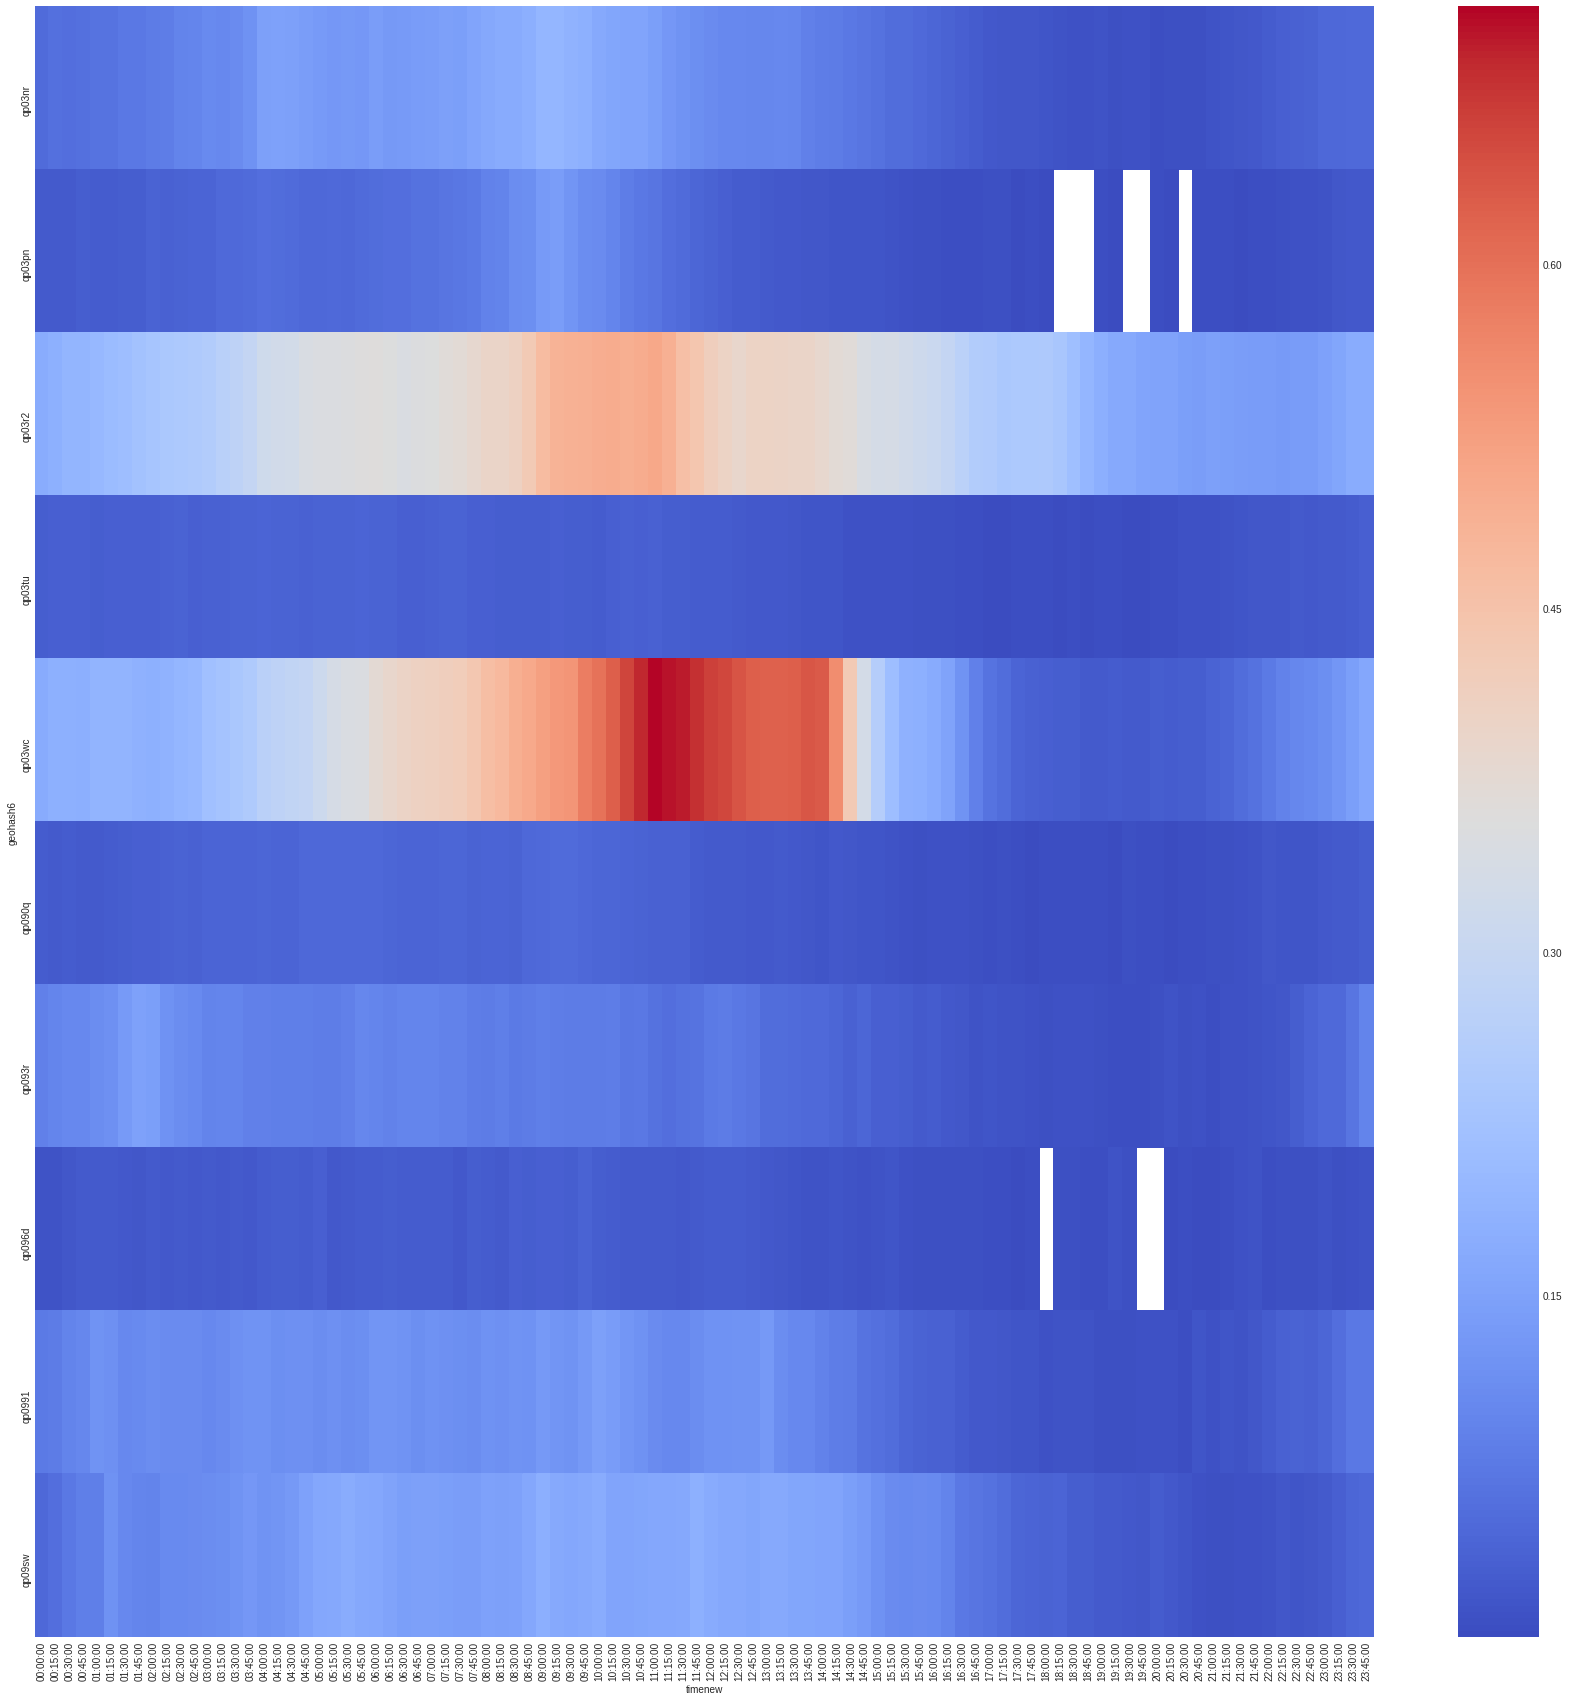

In [17]:
demand_time=data3.pivot_table(values='demand',index='geohash6',columns='timenew')
demand_day=data3.pivot_table(values='demand',index='geohash6',columns='day')
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(demand_time,cmap='coolwarm')

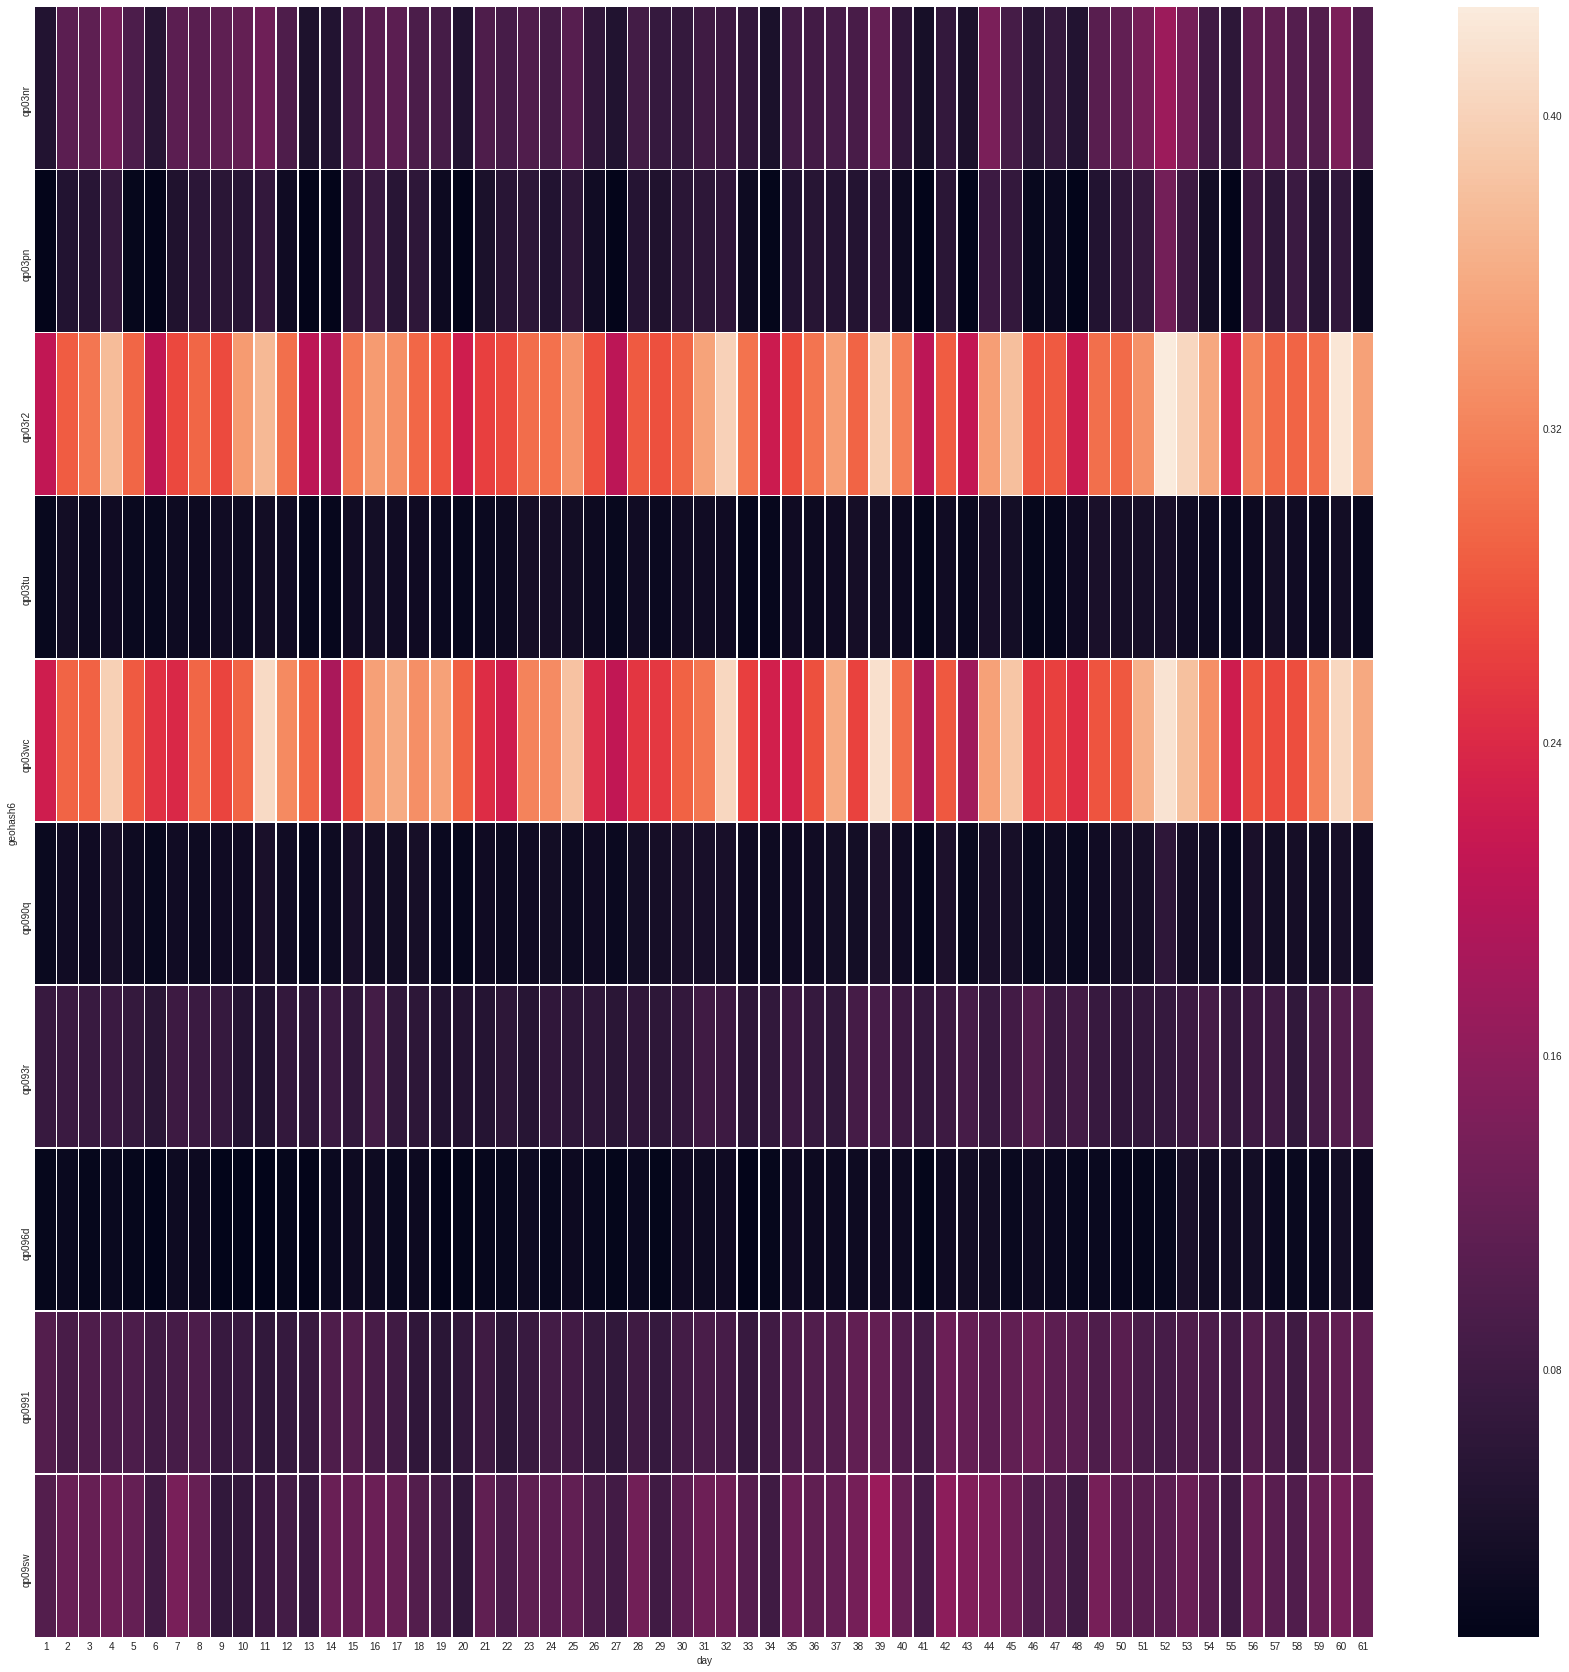

In [18]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(demand_day,linewidths=0.5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 2 columns):
geohash6    object
demand      float64
dtypes: float64(1), object(1)
memory usage: 64.2+ MB


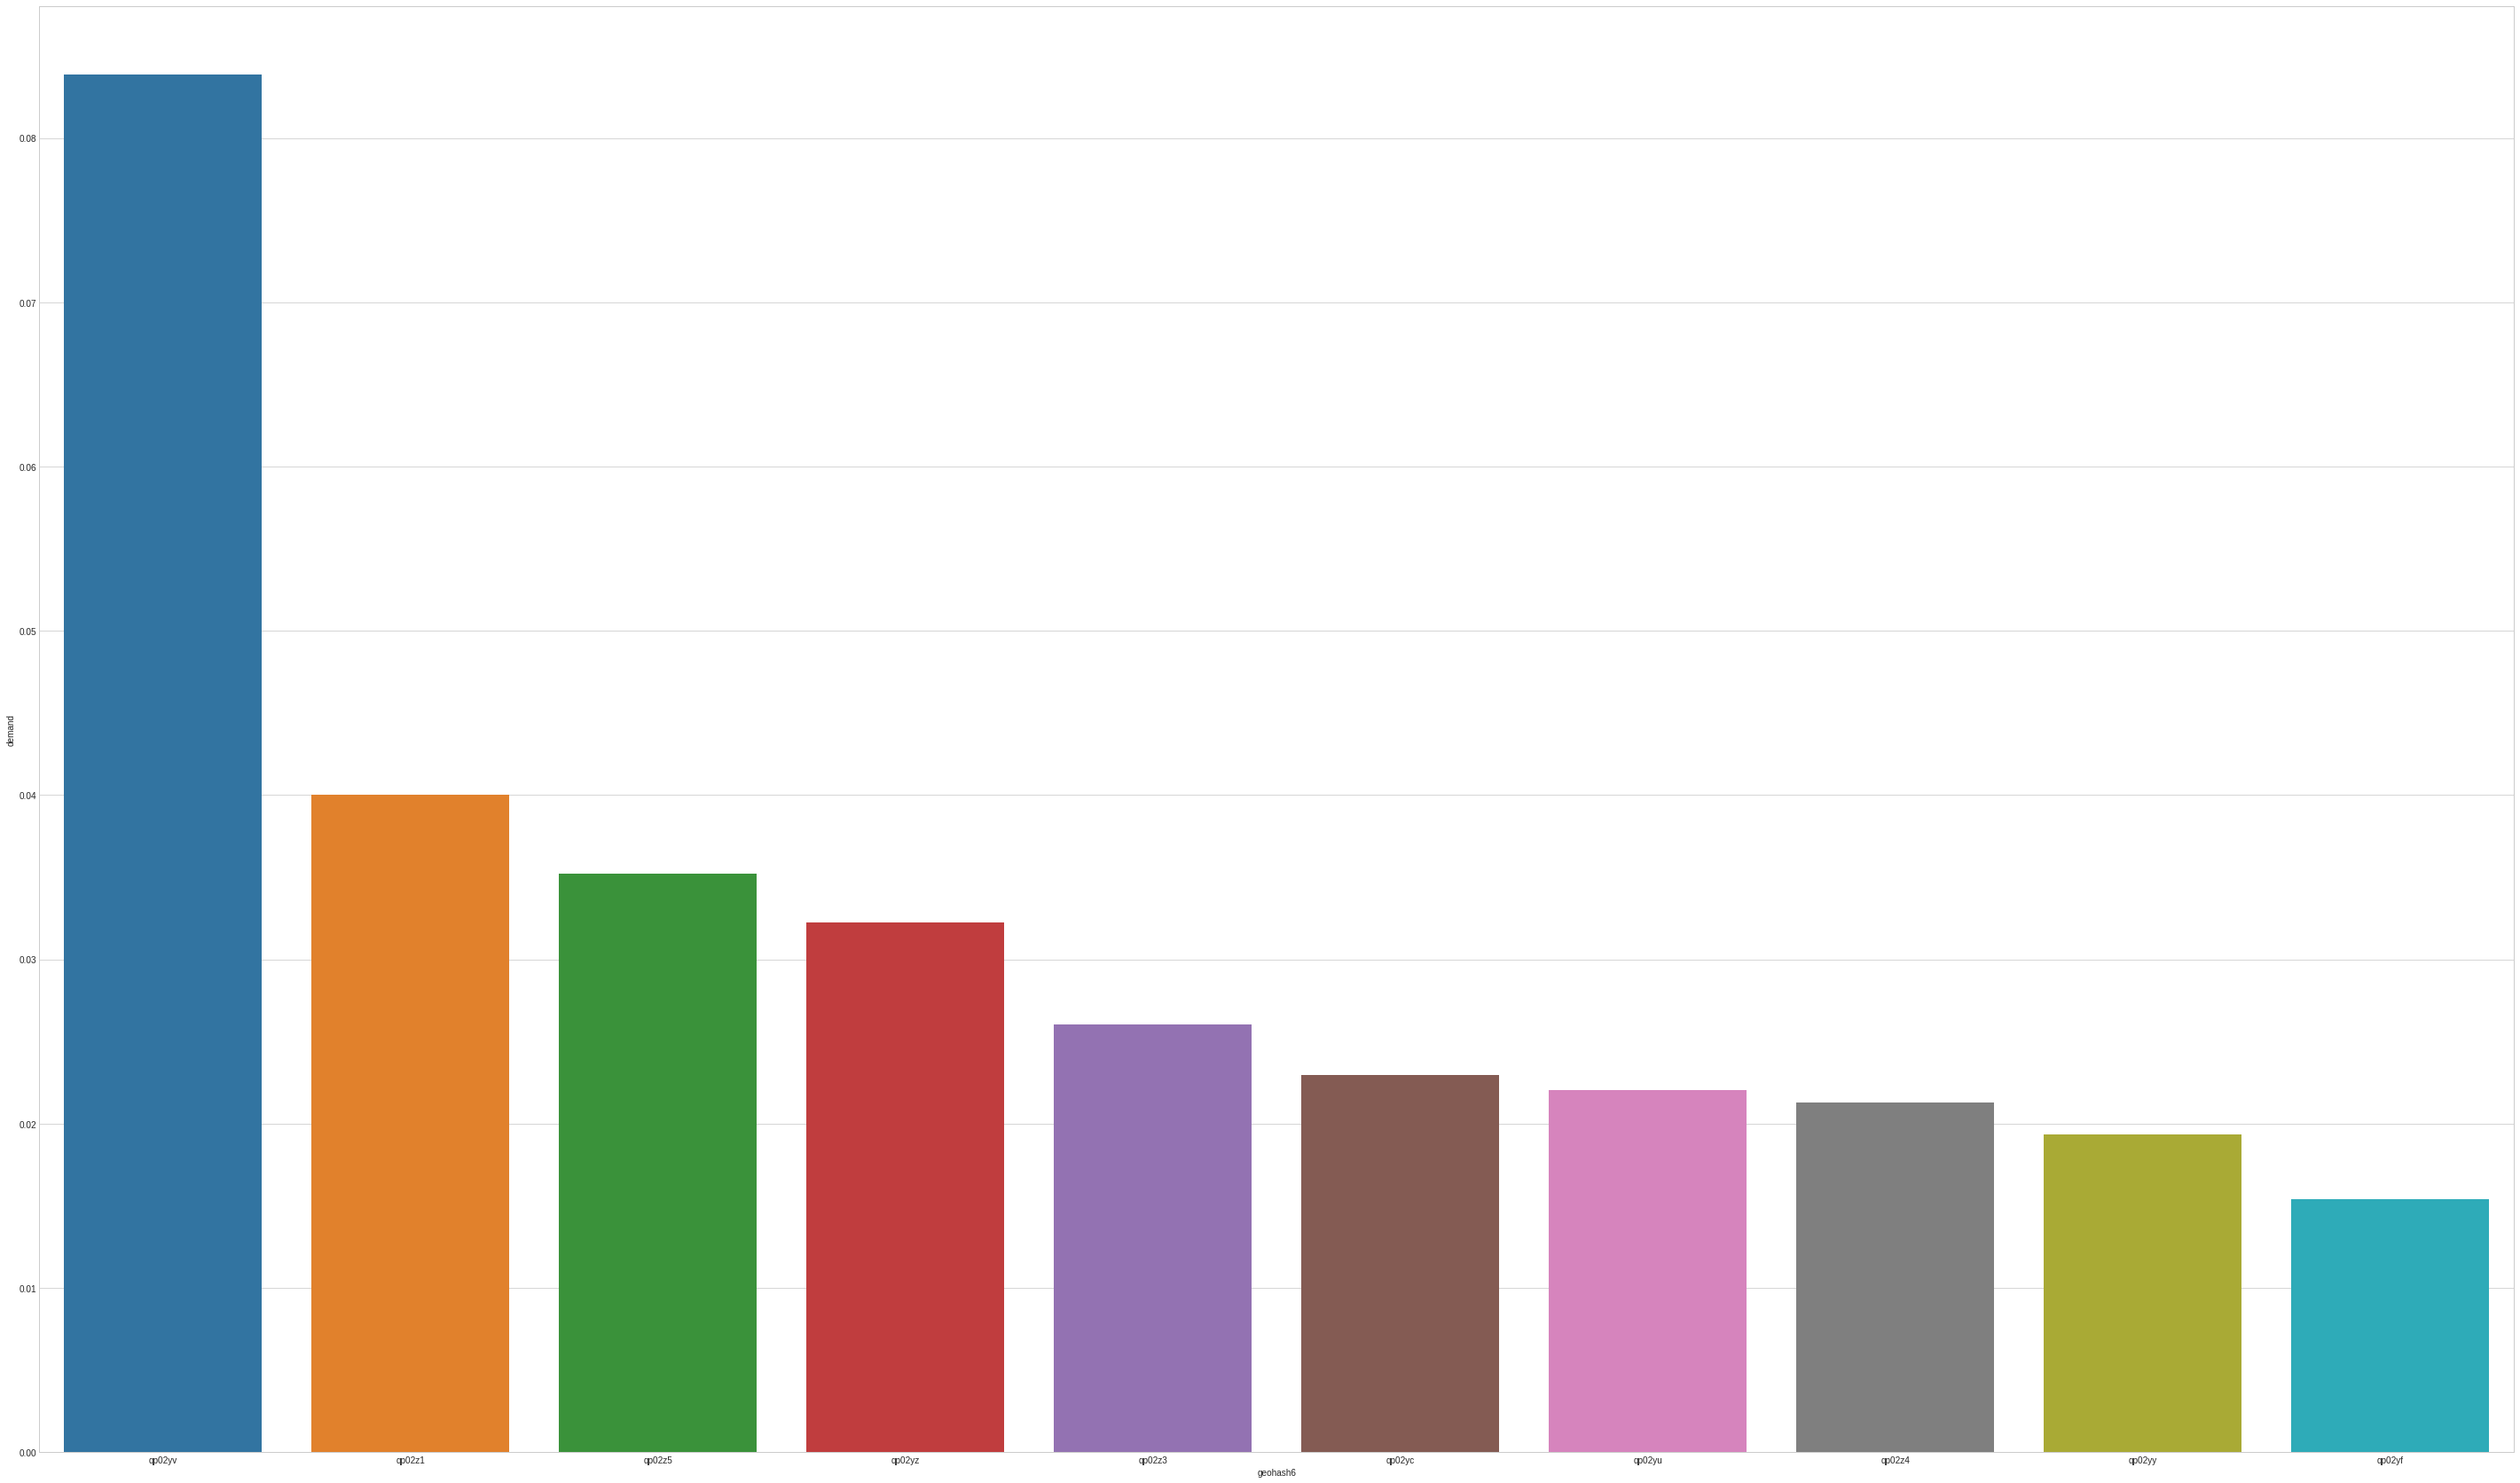

In [19]:
#demand_mean_per_geohash
geohash_demand=pd.DataFrame(DATA[['geohash6','demand']])
#geohash_demand.reset_index(inplace=True)
geohash_demand.info()
geohash_demand.head(10)
df_demand_mean_per_geohash=pd.DataFrame(geohash_demand.groupby('geohash6').mean())
df_demand_mean_per_geohash.reset_index(inplace=True)
df_demand_mean_per_geohash.head(10)
df_demand_mean_per_geohash_sorted=df_demand_mean_per_geohash.head(10).sort_values(by=['demand'], ascending=False)
df_demand_mean_per_geohash_sorted
fig, ax = plt.subplots(figsize=(50,30))
sns.set_context(font_scale=1.5, rc={"font.size": 19.5})
sns.barplot(x='geohash6', y='demand', data=df_demand_mean_per_geohash_sorted)

In [20]:
DATA2=DATA.copy()
DATA2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206321 entries, 0 to 4206320
Data columns (total 7 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
LONGITUDE    float64
LATITUDE     float64
timenew      object
dtypes: float64(3), int64(1), object(3)
memory usage: 224.6+ MB


Feature Engineering

In [21]:
time_hour=[]
time_min=[]
part_of_day=[]
for i in DATA2['timenew']:
    result_hour=int(i.hour) 
    result_min=i.minute
    time_hour.append(result_hour)
    time_min.append(result_min)
DATA2['time_hour']=time_hour
DATA2['time_min']=time_min
#DATA2.info()
for i in DATA2['time_hour']:
    if (i >=4 and i <= 12):
        partsofday='morning'
    elif (i > 12 and i <= 17):
        partsofday='afternoon'
    elif (i > 17 and i <= 21):
        partsofday='evening'
    elif (i > 21):
        partsofday='night'
    elif (i > 0 and i < 4):
        partsofday='night'
    part_of_day.append(partsofday)
DATA2['parts_of_day']=part_of_day

In [22]:
DATA2.head(10)

,geohash6,day,timestamp,demand,LONGITUDE,LATITUDE,timenew,time_hour,time_min,parts_of_day
0,qp03wc,18,20:0,0.020072,-5.35,90.7,20:00:00,20,0,evening
1,qp03pn,10,14:30,0.024721,-5.41,90.7,14:30:00,14,30,afternoon
2,qp09sw,9,6:15,0.102821,-5.33,90.9,06:15:00,6,15,morning
3,qp0991,32,5:0,0.088755,-5.35,90.8,05:00:00,5,0,morning
4,qp090q,15,4:0,0.074468,-5.41,90.7,04:00:00,4,0,morning
5,qp03tu,1,12:15,0.023843,-5.34,90.6,12:15:00,12,15,morning
6,qp096d,25,3:30,0.007460,-5.39,90.8,03:30:00,3,30,night
7,qp03nr,51,20:45,0.000293,-5.41,90.6,20:45:00,20,45,evening
8,qp093r,48,6:15,0.054170,-5.36,90.8,06:15:00,6,15,morning
9,qp03r2,4,22:15,0.123463,-5.40,90.7,22:15:00,22,15,night


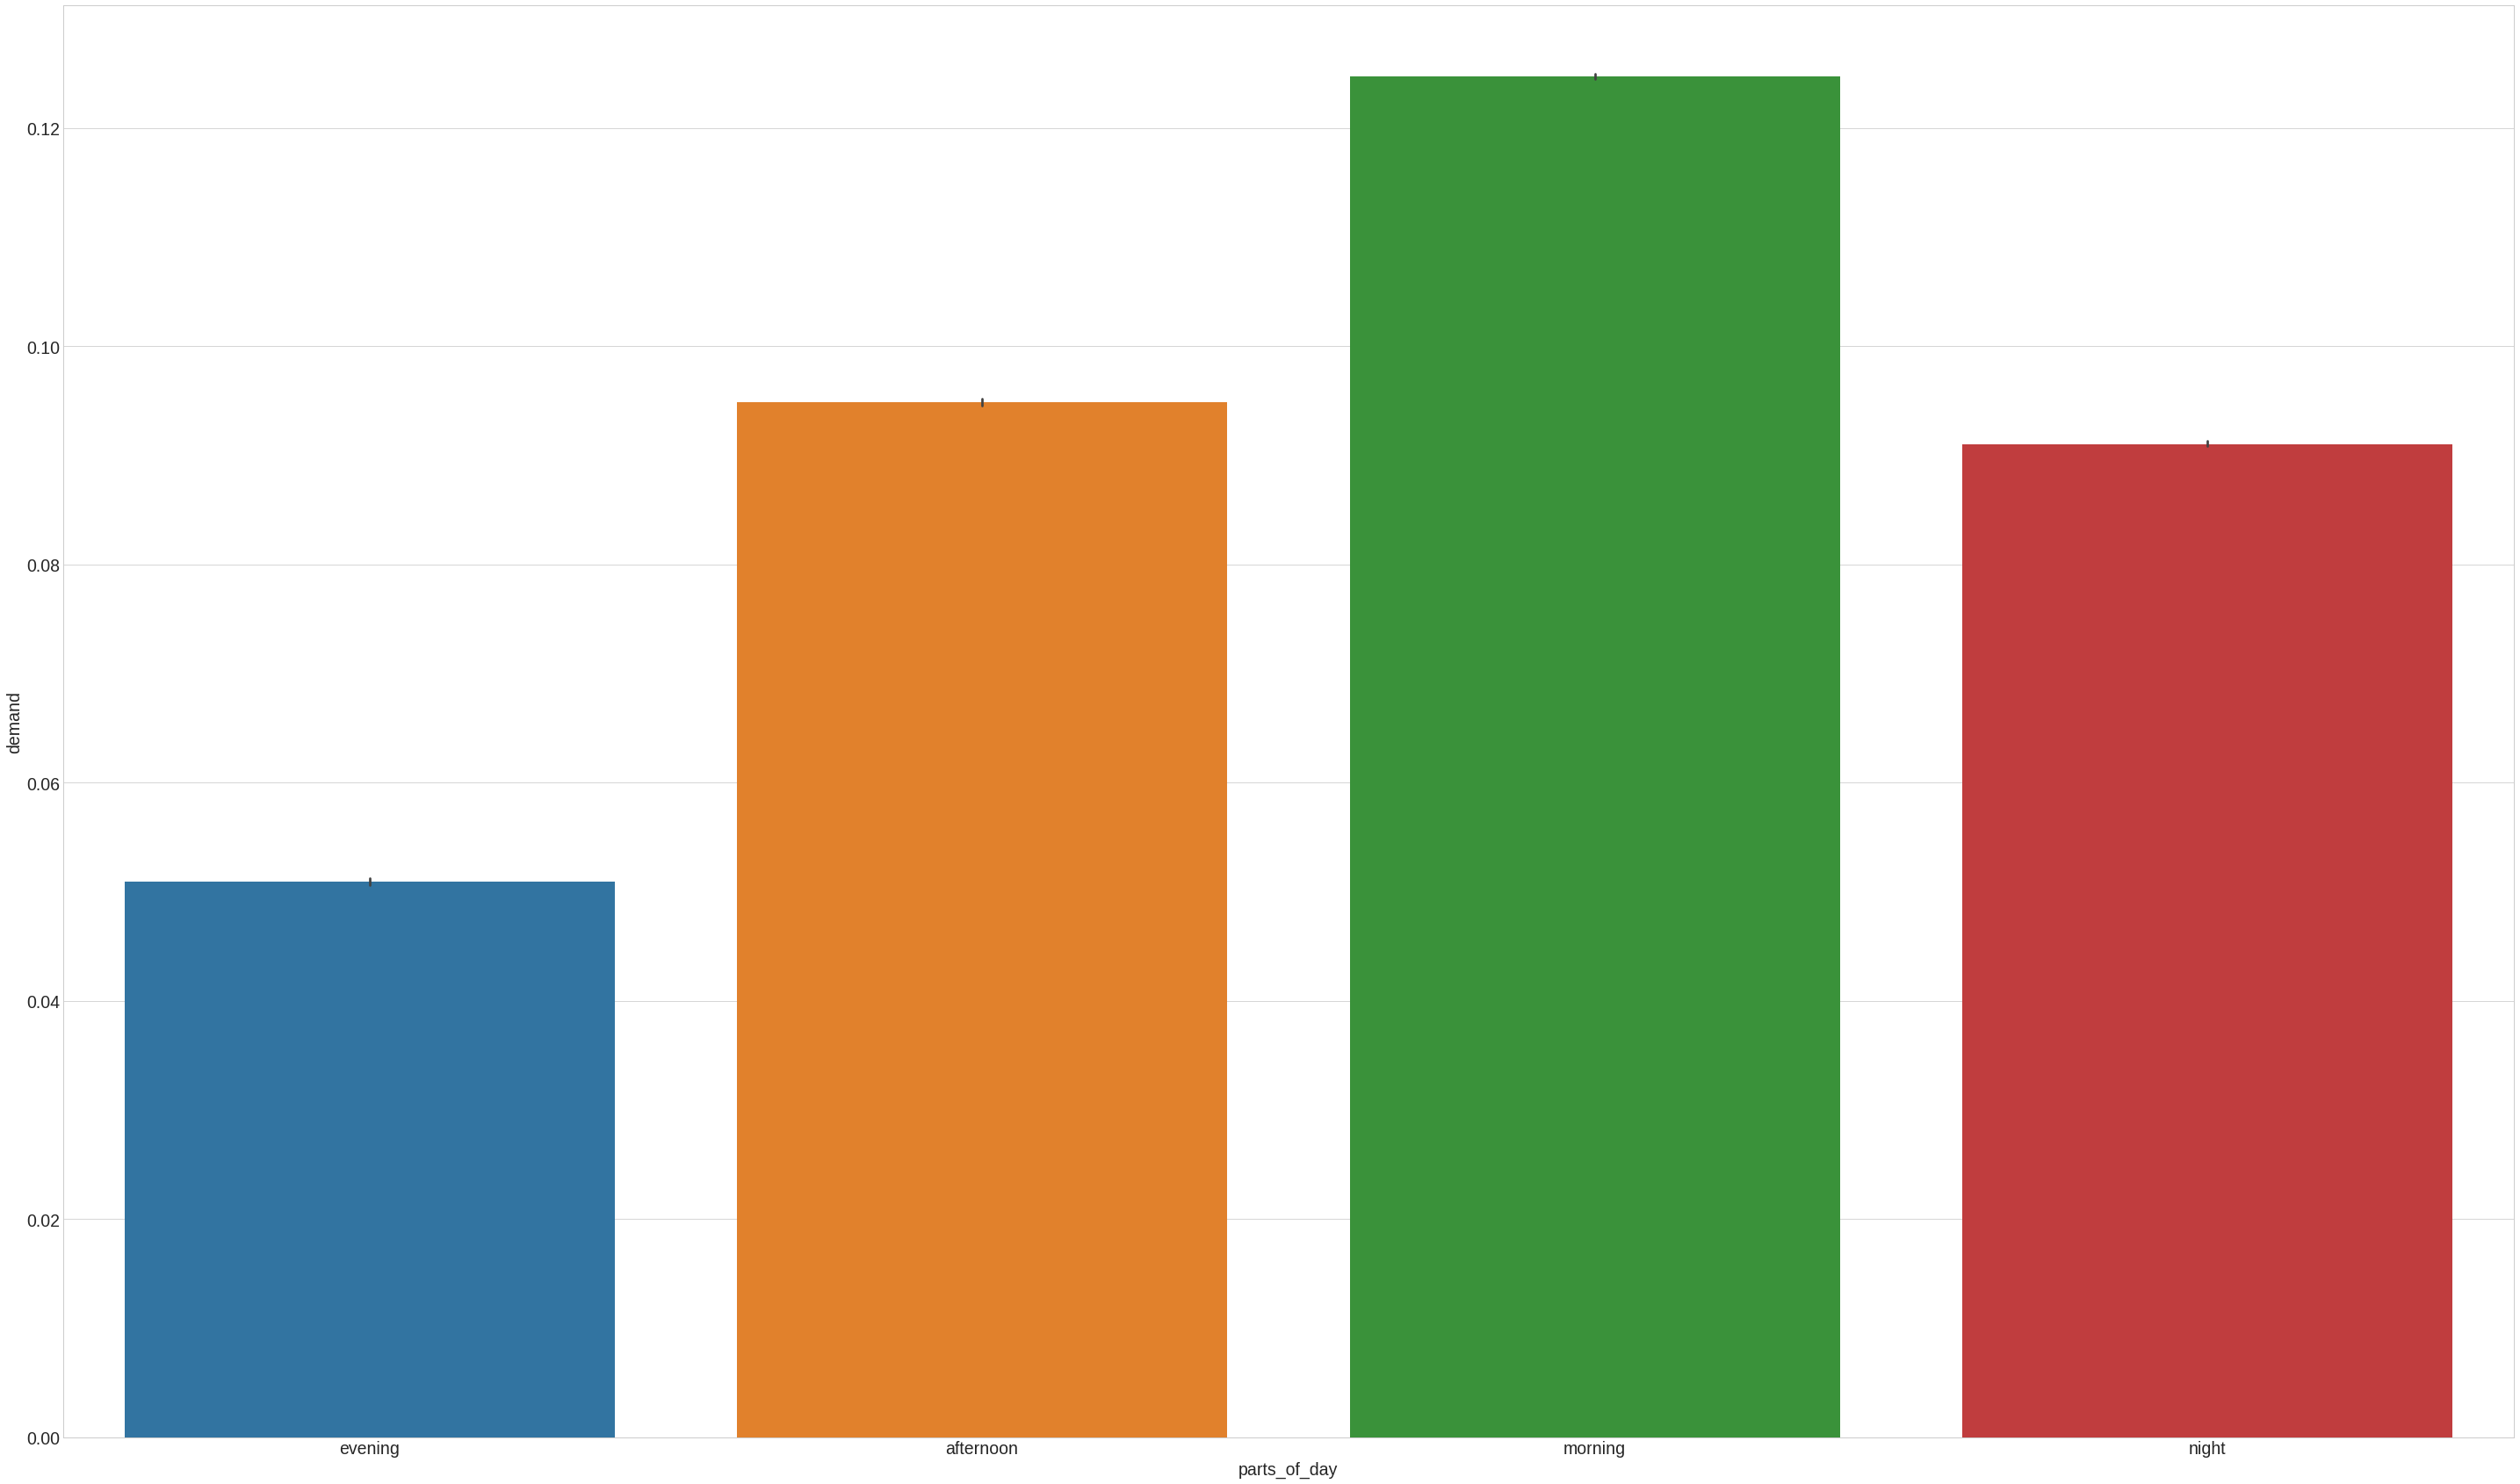

In [23]:
demand_per_pod=pd.DataFrame(DATA2[['demand','parts_of_day']])
#geohash_demand.reset_index(inplace=True)
#demand_parts_of_day.info()
#demand_parts_of_day.head(10)
#df_demand_per_pod=pd.DataFrame(geohash_demand.groupby('parts_of_day').mean())
#df_demand_per_pod.reset_index(inplace=True)
#df_demand_per_pod.head(10)
fig, ax = plt.subplots(figsize=(50,30))
sns.set_context(font_scale=1.5, rc={"font.size": 19.5})
sns.barplot(x='parts_of_day', y='demand', data=demand_per_pod)

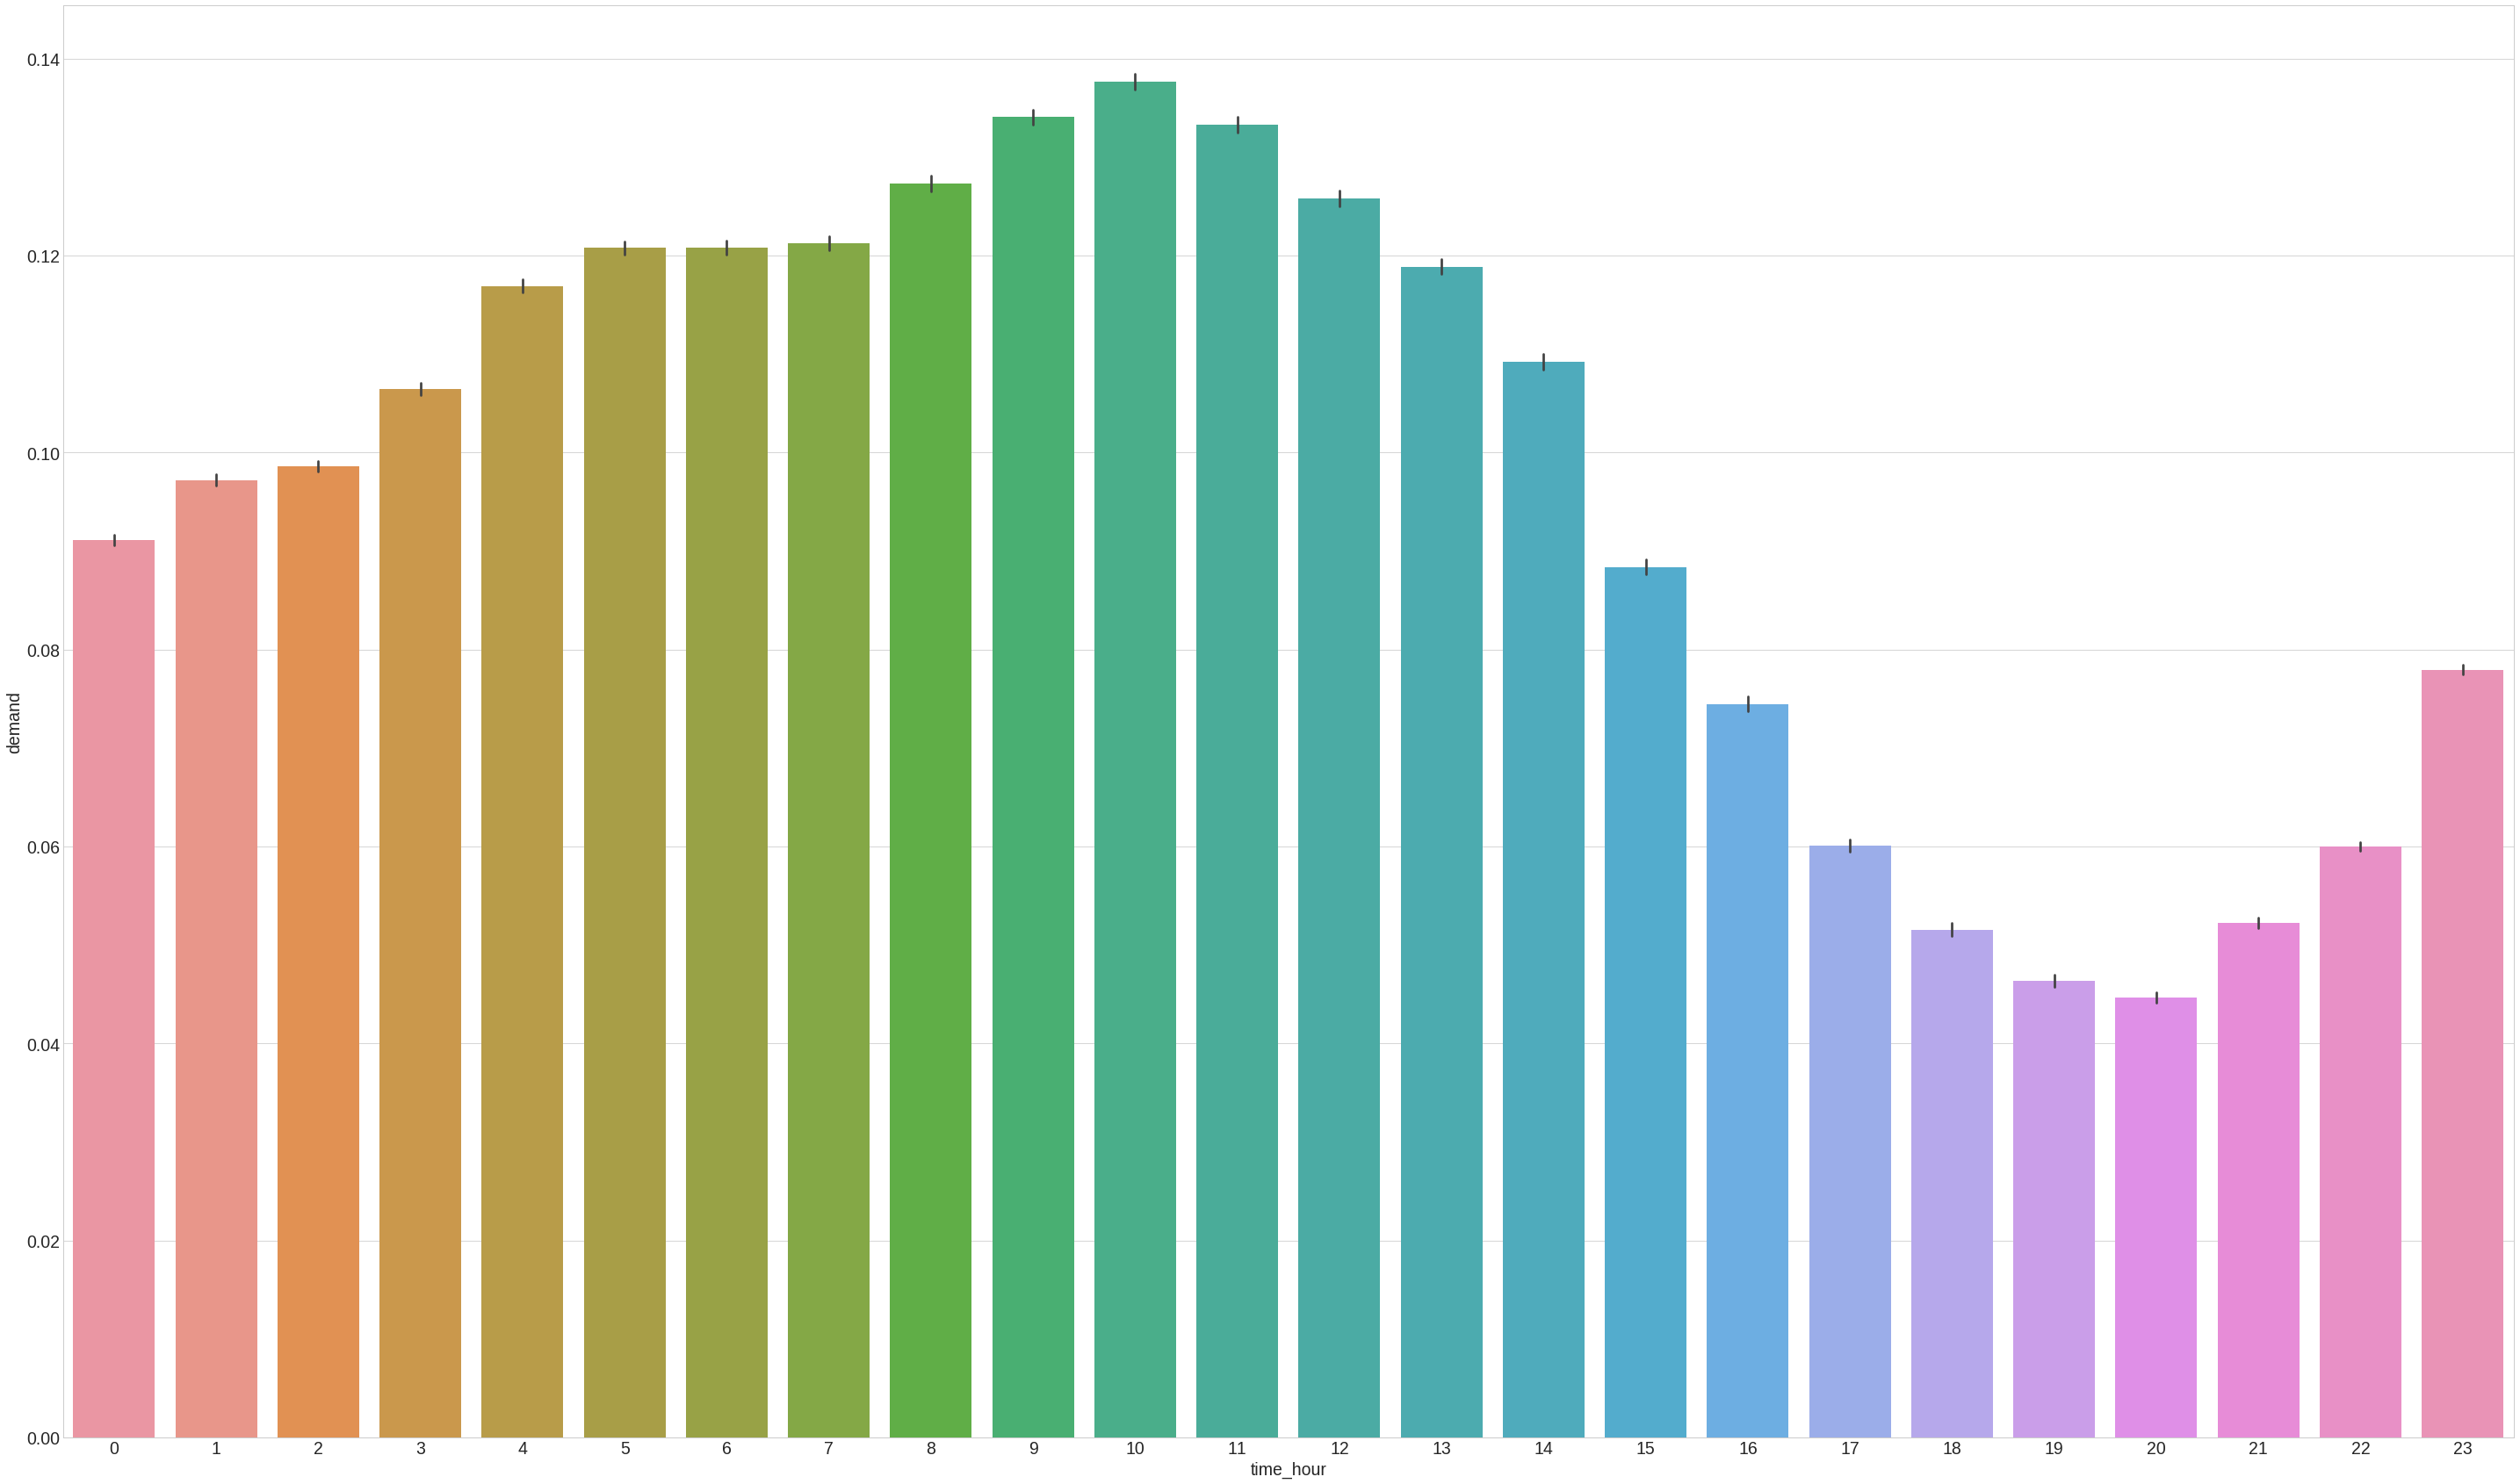

In [24]:
#demand_per_hour
demand_per_hour=pd.DataFrame(DATA2[['demand','time_hour']])
fig, ax = plt.subplots(figsize=(50,30))
sns.set_context(font_scale=1.5, rc={"font.size": 19.5})
sns.barplot(x='time_hour', y='demand', data=demand_per_hour)

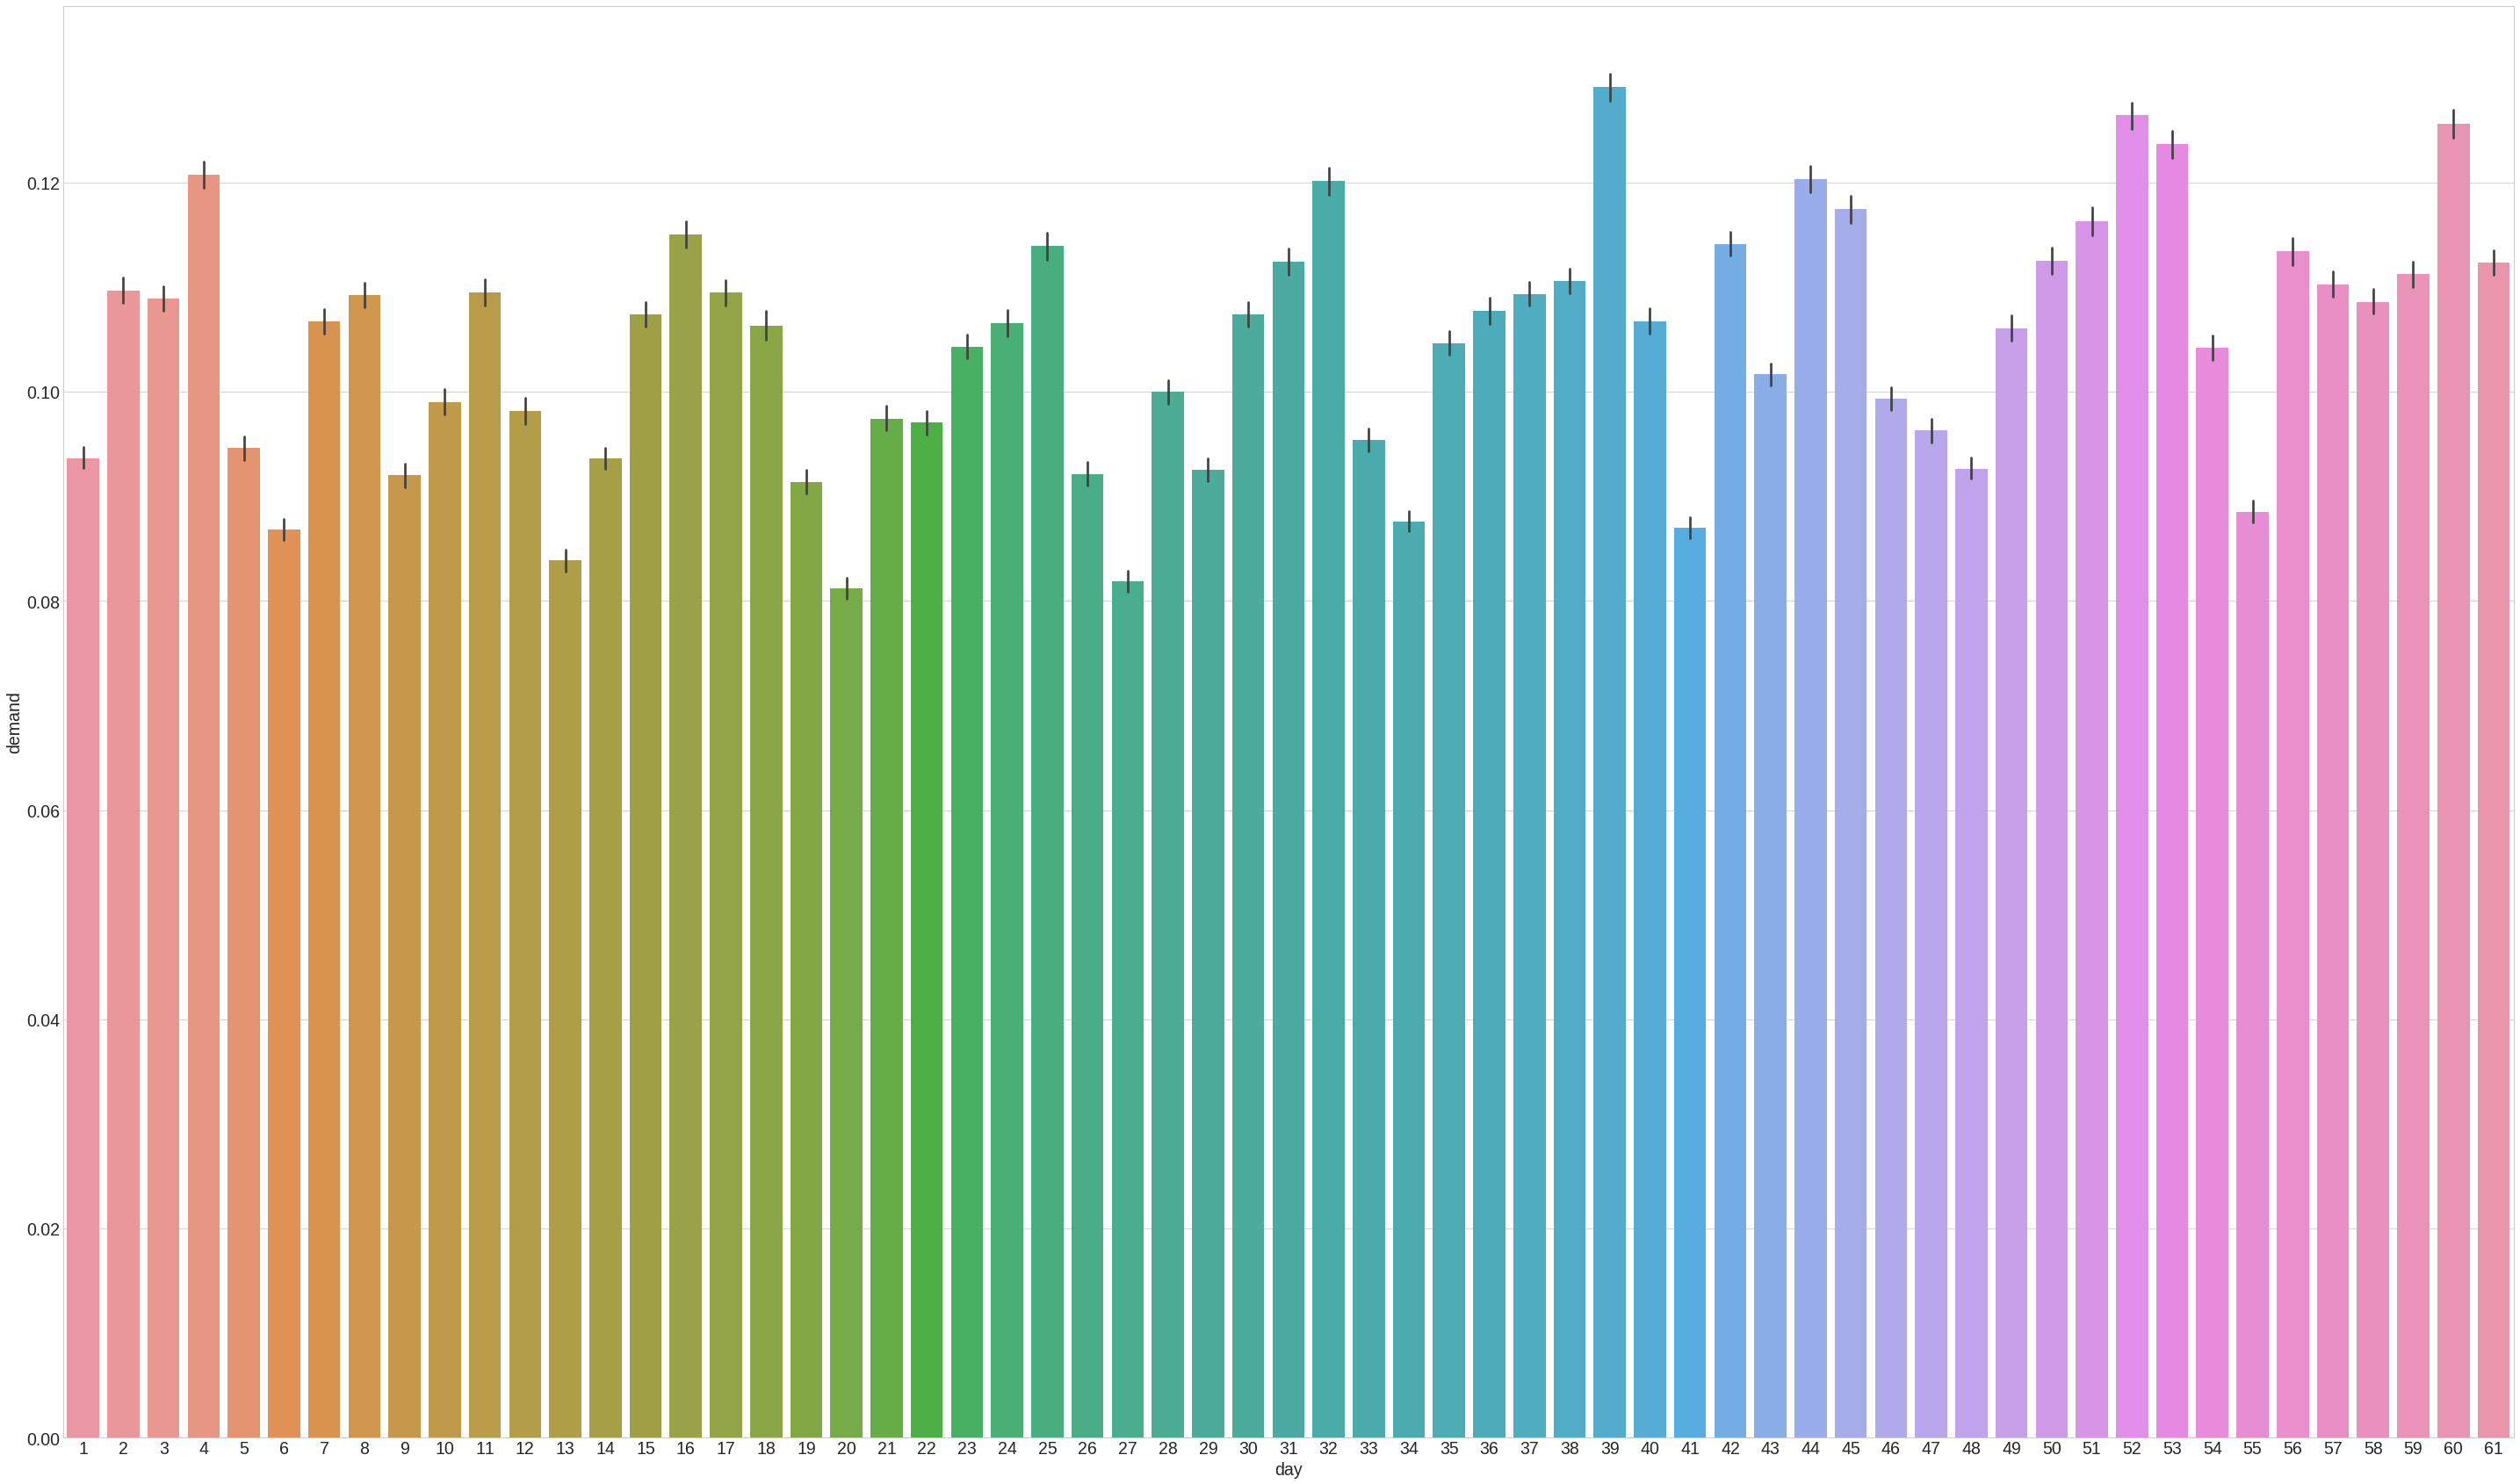

In [25]:
#demand_per_day_sequence
demand_per_day_sequence=pd.DataFrame(DATA2[['demand','day']])
fig, ax = plt.subplots(figsize=(50,30))
sns.set_context(font_scale=1.5, rc={"font.size": 19.5})
sns.barplot(x='day', y='demand', data=demand_per_day_sequence)

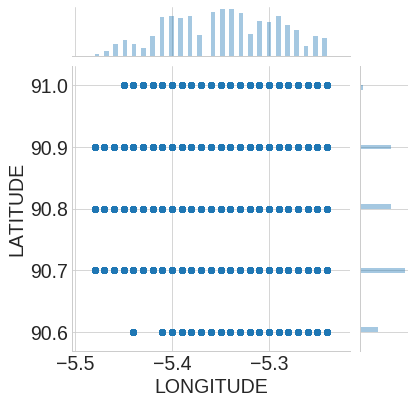

In [26]:
#distribution of longitude and latitude
sns.jointplot(x='LONGITUDE',y='LATITUDE',data=DATA2,kind='scatter')

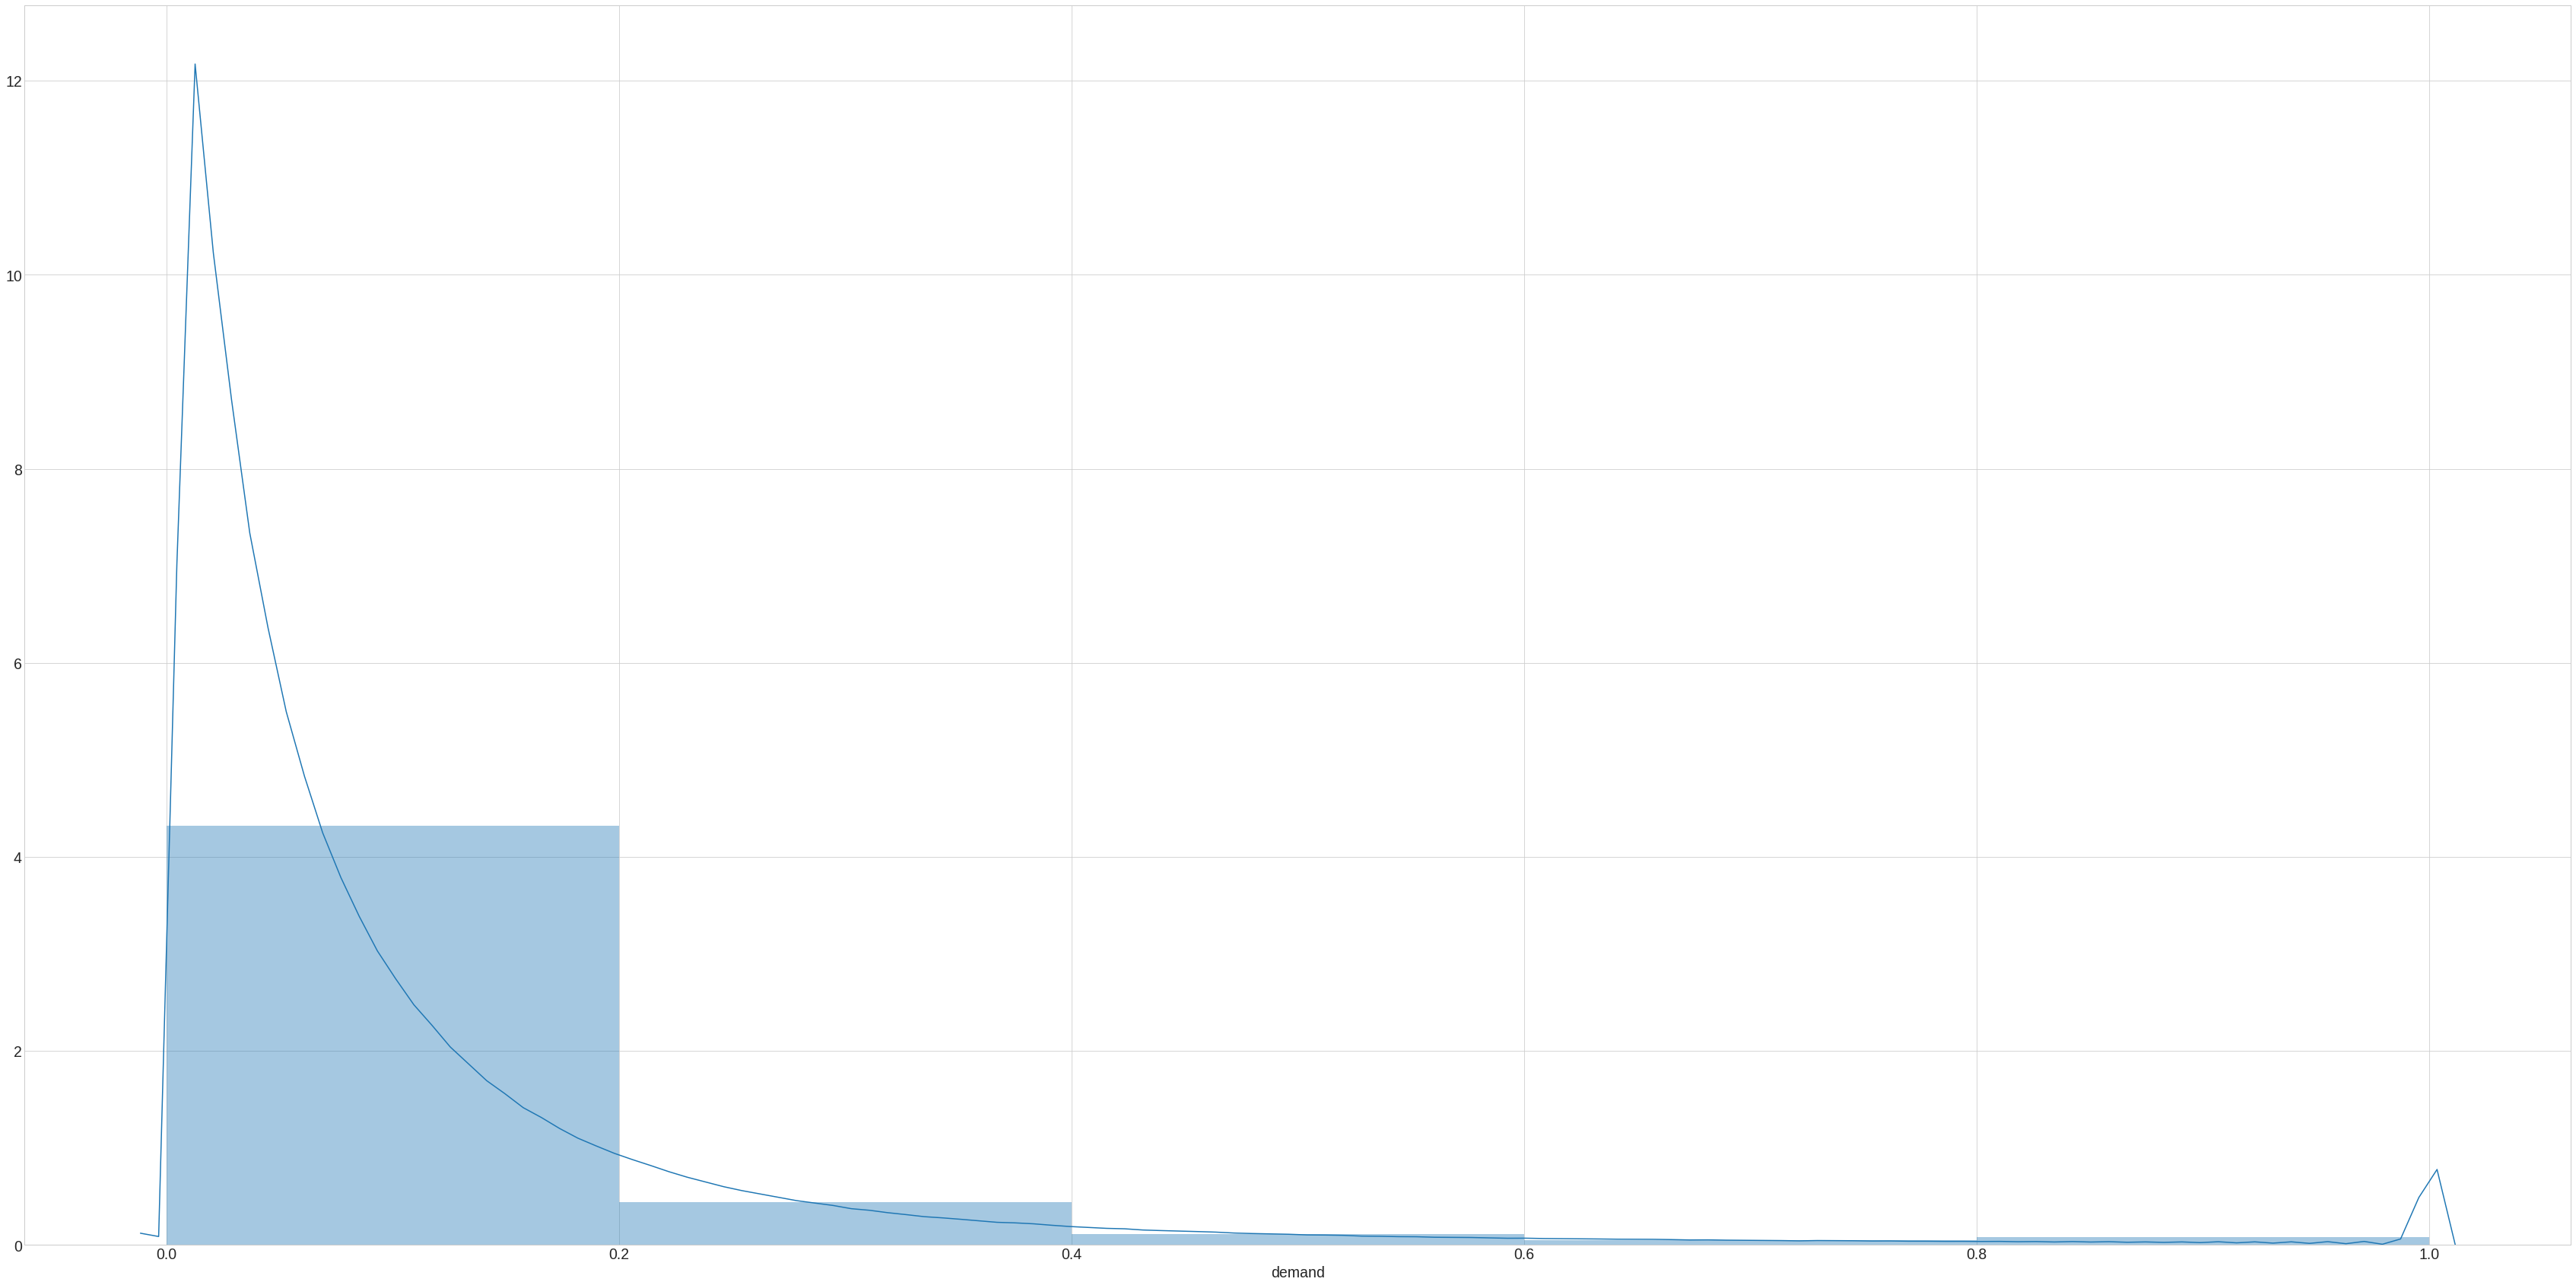

In [27]:
#distribution of demand
fig, ax = plt.subplots(figsize=(60,30))
sns.set_context(font_scale=1.5, rc={"font.size": 19.5})
sns.distplot(DATA2['demand'],bins=5)

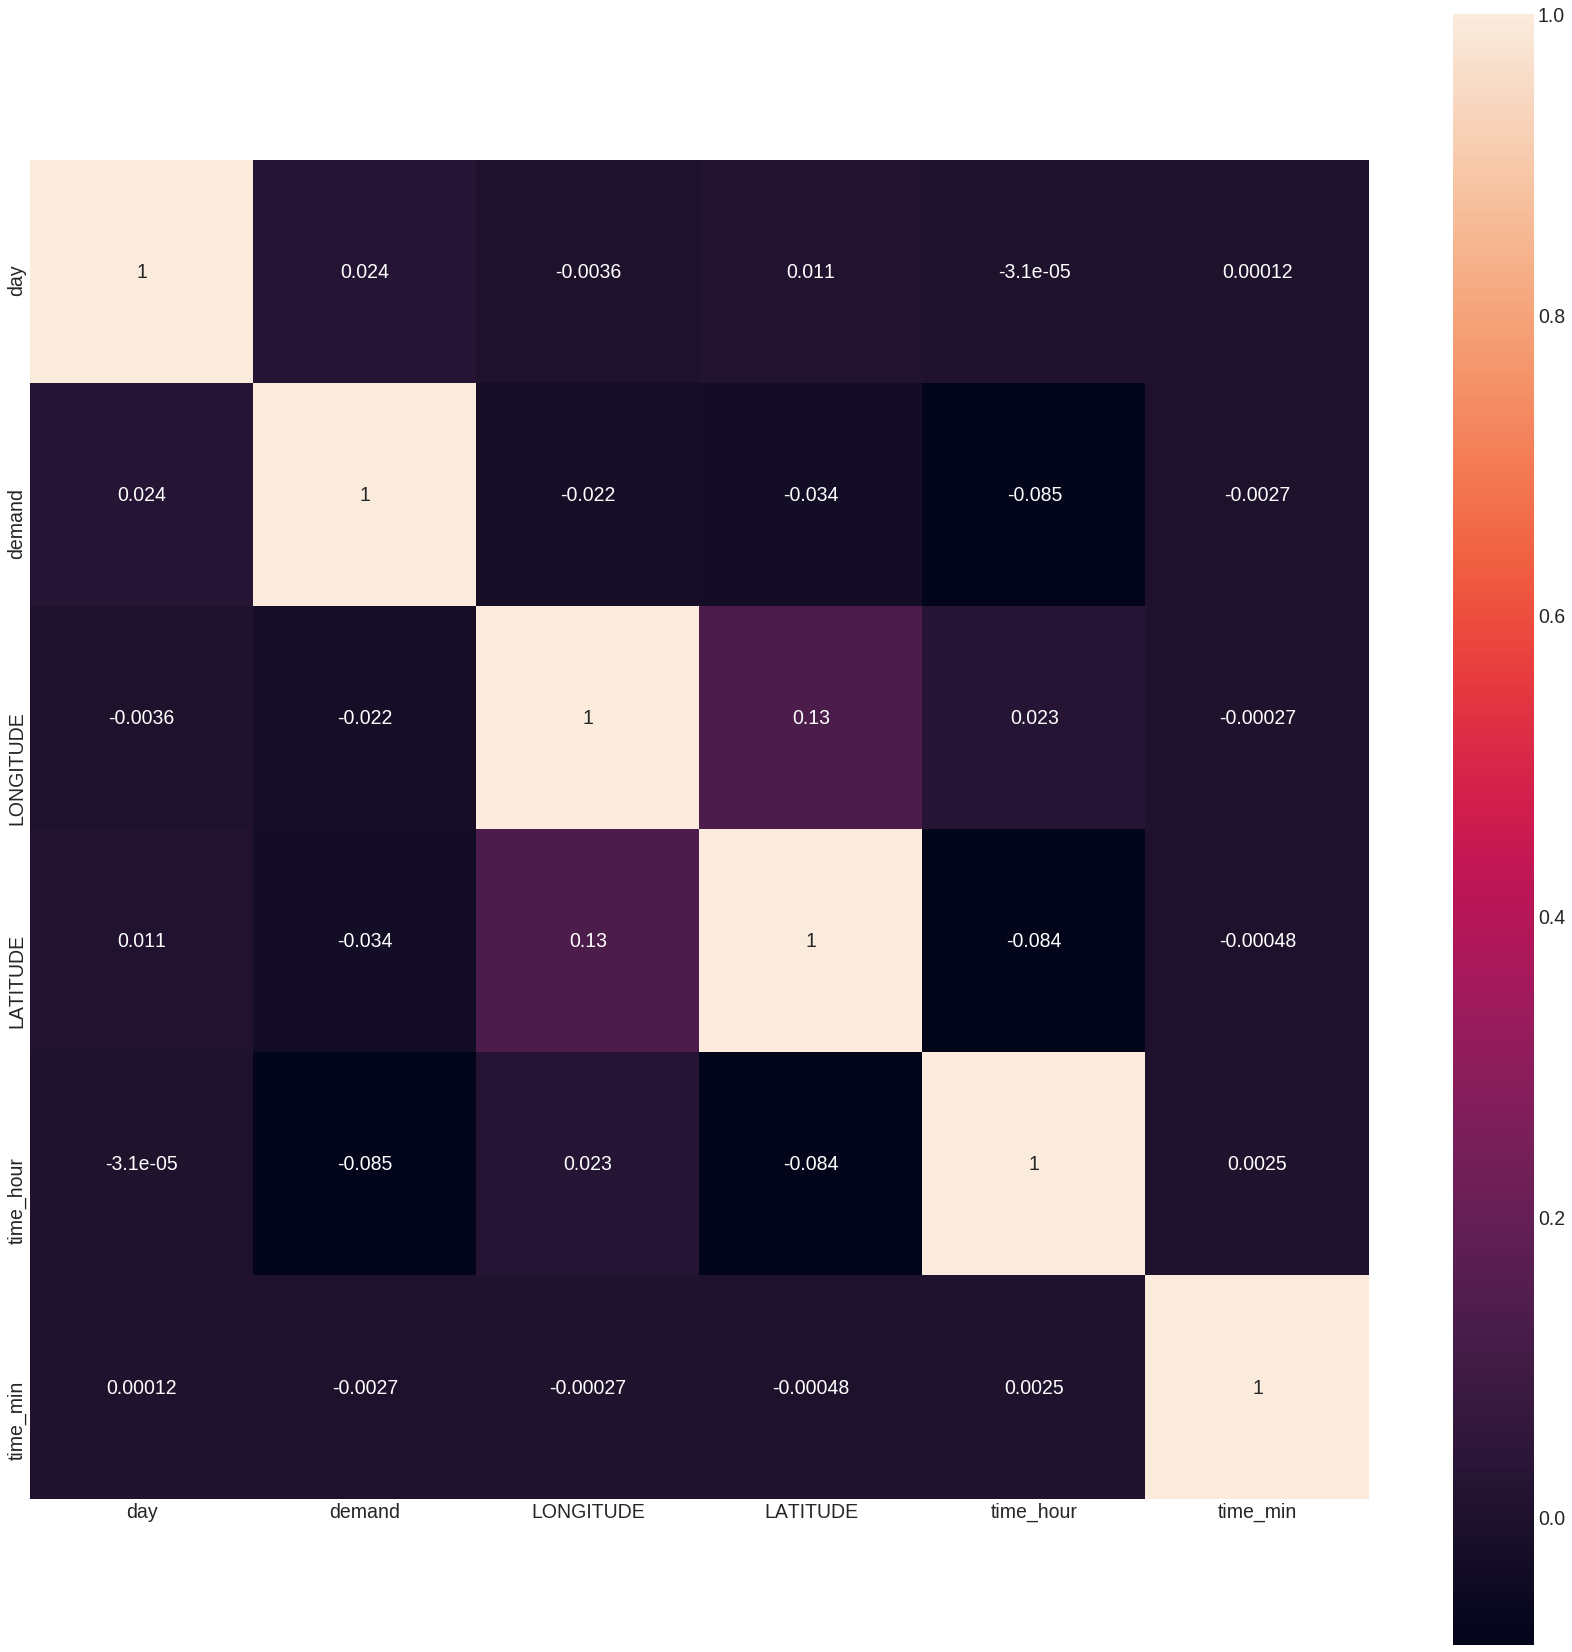

In [28]:
#check correlation
numtrain = DATA2.select_dtypes(include=[np.number])
corr = numtrain.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr,vmax=1,square=True,annot=True)

Modelling

In [29]:
#Linear Regression
x=DATA2[['day','LONGITUDE','LATITUDE','time_hour','time_min']]
x.head()
y=DATA2['demand']
y.head()
#Split into training and test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=101)
x_train.head()
#stratify itu mensampling data
lm=LinearRegression()
#kita cari
lm.fit(x_train,y_train)
x.columns
lm.coef_
lm.intercept_
coeff_df=pd.DataFrame(lm.coef_,x.columns,columns=['Coefficient'])
print(coeff_df)
predictions=lm.predict(x_test)
predictions
#plt.scatter(y_test,predictions)

print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test,predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

           Coefficient
day           0.000218
LONGITUDE    -0.041327
LATITUDE     -0.059113
time_hour    -0.002149
time_min     -0.000024
MAE: 0.09640493868264813
MSE: 0.02508635173714825
RMSE: 0.15838671578496805


In [30]:
le = preprocessing.LabelEncoder()
le.fit(DATA2['parts_of_day'])
tr=le.transform(DATA2['parts_of_day'])
#DATA2.parts_of_day.apply(LabelEncoder().fit_transform)
#DATA2.head(10)
DATA2['pod_encoded']=tr

In [31]:
DATA2.head(10)

,geohash6,day,timestamp,demand,LONGITUDE,LATITUDE,timenew,time_hour,time_min,parts_of_day,pod_encoded
0,qp03wc,18,20:0,0.020072,-5.35,90.7,20:00:00,20,0,evening,1
1,qp03pn,10,14:30,0.024721,-5.41,90.7,14:30:00,14,30,afternoon,0
2,qp09sw,9,6:15,0.102821,-5.33,90.9,06:15:00,6,15,morning,2
3,qp0991,32,5:0,0.088755,-5.35,90.8,05:00:00,5,0,morning,2
4,qp090q,15,4:0,0.074468,-5.41,90.7,04:00:00,4,0,morning,2
5,qp03tu,1,12:15,0.023843,-5.34,90.6,12:15:00,12,15,morning,2
6,qp096d,25,3:30,0.007460,-5.39,90.8,03:30:00,3,30,night,3
7,qp03nr,51,20:45,0.000293,-5.41,90.6,20:45:00,20,45,evening,1
8,qp093r,48,6:15,0.054170,-5.36,90.8,06:15:00,6,15,morning,2
9,qp03r2,4,22:15,0.123463,-5.40,90.7,22:15:00,22,15,night,3


In [32]:
#Linear Regression with feature engineering
x=DATA2[['day','LONGITUDE','LATITUDE','time_hour','time_min','pod_encoded']]
x.head()
y=DATA2['demand']
y.head()
#Split into training and test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=101)
x_train.head()
#stratify itu mensampling data
lm=LinearRegression()
#kita cari
lm.fit(x_train,y_train)
x.columns
lm.coef_
lm.intercept_
coeff_df=pd.DataFrame(lm.coef_,x.columns,columns=['Coefficient'])
print(coeff_df)
predictions=lm.predict(x_test)
predictions
#plt.scatter(y_test,predictions)

print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',metrics.mean_squared_error(y_test,predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,predictions)))

             Coefficient
day             0.000218
LONGITUDE      -0.041257
LATITUDE       -0.059052
time_hour      -0.002190
time_min       -0.000023
pod_encoded    -0.000647
MAE: 0.09641463878152683
MSE: 0.02508608991344004
RMSE: 0.15838588924976885


In [33]:
# OLS model
def get_input_matrix(df):
    return np.column_stack((df.LONGITUDE, df.LATITUDE, df.day,df.time_hour,df.time_min,np.ones(len(df))))

train_X = get_input_matrix(DATA2)
train_y = np.array(DATA2['demand'])

print(train_X.shape)
print(train_y.shape)

#Determine weight vector w.
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

w_OLS = np.matmul(np.matmul(np.linalg.inv(np.matmul(train_X.T, train_X)), train_X.T), train_y)
print(w_OLS)

model = sm.OLS(train_y,train_X)
results = model.fit()
test_X = get_input_matrix(x_test)
test_y_predictions = np.matmul(test_X, w).round(decimals = 2)
print('MAE:',metrics.mean_absolute_error(y_test,test_y_predictions))
print('MSE:',metrics.mean_squared_error(y_test,test_y_predictions))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,test_y_predictions)))

(4206321, 6)
(4206321,)
[-4.03638766e-02 -5.88372766e-02  2.16334942e-04 -2.14485327e-03
 -2.38499304e-05  5.24446811e+00]
[-4.03638768e-02 -5.88372766e-02  2.16334942e-04 -2.14485327e-03
 -2.38499304e-05  5.24446810e+00]
MAE: 0.09641602566856468
MSE: 0.025094577158140695
RMSE: 0.15841267991591043


In [34]:
#Linear Regression with cv
x=DATA2[['day','LONGITUDE','LATITUDE','time_hour','time_min']]
x.head()
y=DATA2['demand']
y.head()
#Split into training and test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3, random_state=101)
x_train.head()
#stratify itu mensampling data
lm=LinearRegression()
#kita cari
lm.fit(x_train,y_train)
x.columns
lm.coef_
lm.intercept_
coeff_df=pd.DataFrame(lm.coef_,x.columns,columns=['Coefficient'])
print(coeff_df)
predictions=lm.predict(x_test)
predictions
#plt.scatter(y_test,predictions)

print('MAE:',metrics.mean_absolute_error(y_test,predictions))
print('MSE:',-1*(np.mean(cross_val_score(lm,x_train,y_train,scoring='neg_mean_squared_error',cv=5))))
print('RMSE:',np.sqrt(-1*(np.mean(cross_val_score(lm,x_train,y_train,scoring='neg_mean_squared_error',cv=5)))))

           Coefficient
day           0.000218
LONGITUDE    -0.041327
LATITUDE     -0.059113
time_hour    -0.002149
time_min     -0.000024
MAE: 0.09640493868264813
MSE: 0.025133737136243468
RMSE: 0.15853623288145668


In [35]:
#Ridge regression
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
ridge = Ridge()
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
ridge_regressor = GridSearchCV(ridge, parameters,scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(x_train,y_train)
ridge_regressor.best_params_
ridge_regressor.best_score_
print('MSE:',-1*(ridge_regressor.best_score_))
print('RMSE:',np.sqrt(-1*(ridge_regressor.best_score_)))

MSE: 0.025133737216353744
RMSE: 0.15853623313411272
